# SVM: ANALYZE tld_reseller model performance comparison (w/ reseller_geo)

In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_05_metalearning"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

## List tld_reseller labels

In [5]:
tld_reseller_lookup_df = expiry_train_df_1 %>% group_by(tld_registrar_index, reseller) %>% tally() %>% arrange(desc(n))
tld_reseller_lookup_df %>% head()

tld_registrar_index,reseller,n
<chr>,<chr>,<int>
sitegmo,gmo,106569
funalibaba,alibaba,72690
sitenamecheap,namecheap,53536
pwnamecheap,namecheap,50470
onlinego daddy,go daddy,42162
sitegandi sas,gandi sas,35309


## Load PREPed tld_reseller compare

In [6]:
predictions_df <- read.csv("../../data/tld_reseller_compare_predictions.csv")
metrics_df <- read.csv("../../data/tld_reseller_compare_metrics.csv")

dim(predictions_df)
head(predictions_df)
dim(metrics_df)
head(metrics_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


[1] 1723   15

,tld_registrar_index,reseller,n,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sitegmo,gmo,106569,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721
2,funalibaba,alibaba,72690,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023
3,sitenamecheap,namecheap,53536,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178
4,pwnamecheap,namecheap,50470,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905
5,onlinego daddy,go daddy,42162,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328
6,sitegandi sas,gandi sas,35309,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108


## Add reseller_geo to train_df before feature eng

In [7]:
head(expiry_train_df_1)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


In [8]:
system("gsutil cp gs://data_input/PredictiveModelAnalysis_AnomalyRegistrars.csv /home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- apply(anomalyDF, 2, function(x) trimws(x,which = c("both")) )
geoLookupDF <- unique(anomalyDF[,c('reseller','reseller_country','reseller_geo')])
geoLookupDF <- as.data.frame(geoLookupDF)
head(geoLookupDF)

,reseller,reseller_country,reseller_geo
,<fct>,<fct>,<fct>
1,007names,United States,United States
2,0101 internet,Hong Kong,China
3,1&1 internet,Germany,EU
4,101 domain,United States,United States
5,101domain discovery,Germany,EU
6,10dencehispahard,Spain,EU


In [9]:
# number of unique geos per reseller
geoLookupDF %>%
  group_by(reseller) %>%
  summarise(u_geo = n_distinct(reseller_geo))  %>%
  filter(u_geo>1)

`summarise()` ungrouping output (override with `.groups` argument)



reseller,u_geo
<fct>,<int>
hostgator,2
moniker,2
psi-japan,2
registrarsec,2
uk2,2
NA,2


In [10]:
# number of unique geos per reseller-country
geoLookupDF %>%
  group_by(reseller, reseller_country) %>%
  summarise(u_geo = n_distinct(reseller_geo))  %>%
  filter(u_geo>1)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,reseller_country,u_geo
<fct>,<fct>,<int>
NA,NA,2


In [11]:
geoLookupDF %>% filter(is.na(reseller))

reseller,reseller_country,reseller_geo
<fct>,<fct>,<fct>
NA,NA,Others
NA,NA,NA


In [12]:
# ensure correct number of dimm
dim(expiry_train_df_1)
expiry_train_df_2 <- merge(expiry_train_df_1,geoLookupDF,on=c('reseller','reseller_country'), all.x = TRUE)
dim(expiry_train_df_2)
head(expiry_train_df_2)


[1] 1188250      39

[1] 1188250      40

reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo
<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>
1&1 internet,Germany,FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1,EU


In [13]:
# replace original
expiry_train_df_1 <- expiry_train_df_2

In [14]:
expiry_train_df_1 %>% filter(reseller_country=='') %>% select(reseller)

reseller
<chr>
anygaming
electron networks
innovadeus
innovadeus
netclues
ownregistrar
ownregistrar
ownregistrar
ownregistrar


In [15]:
# number of unique reseller_country and reseller_geo for eachtld_registrar_index
expiry_train_df_1 %>%
  group_by(tld_registrar_index) %>%
  summarise(u_cntry = n_distinct(reseller_country),
         u_geo = n_distinct(reseller_geo))  %>%
  filter(u_cntry>1)

`summarise()` ungrouping output (override with `.groups` argument)



tld_registrar_index,u_cntry,u_geo
<chr>,<int>,<int>
funkey-systems,2,2
funtucows,2,2
onlineinnovadeus,2,1
onlinekey-systems,2,2
onlineownregistrar,2,2
onlineshopify,2,2
onlinetucows,2,2
onlineuk2,2,2
presskey-systems,2,2


## Feature Engineering for tld-reseller level 

In [16]:
# new geo level feature eng
geo_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  mutate(geo_maj = reseller_geo[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,geo_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(geo_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [17]:
# new geo level feature eng
geo_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(geo_cnt = n_distinct(reseller_geo)) %>%
  pull(geo_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [18]:
count_pct <- function(df) {
  return(
    df %>%
      tally %>% 
      mutate(n_prp = n/sum(n))
  )
}

In [19]:
tld_reseller_names = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

In [20]:
count_obs = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
    pull(n)

In [21]:
ren_prp = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), ren_prp = sum(renewal_status=='Renewed')/sum(n))  %>% 
    arrange(desc(n)) %>% 
    pull(ren_prp)

`summarise()` ungrouping output (override with `.groups` argument)



In [22]:
# not informative -- tld_cnt always = 1 so tld_rat is ismply mult.inverse of count_obs
tld_rat = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n) %>% 
    arrange(desc(n)) %>%
    pull(tld_rat)

`summarise()` ungrouping output (override with `.groups` argument)



In [23]:
country_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [24]:
country_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [25]:
region_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [26]:
region_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [27]:
daydom_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              daydom_min = min(day_domains), 
              daydom_max = max(day_domains), 
              daydom_mean = mean(day_domains, na.rm = TRUE), 
              daydom_rng = daydom_max - daydom_min, 
              daydom_std = sd(day_domains, na.rm = TRUE), 
              daydom_skew = skewness(day_domains, na.rm = TRUE), 
              daydom_kurt = kurtosis(day_domains, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

daydom_min <- daydom_stats %>% pull(daydom_min)
daydom_max <- daydom_stats %>% pull(daydom_max)
daydom_mean <- daydom_stats %>% pull(daydom_mean)
daydom_rng <- daydom_stats %>% pull(daydom_rng)
daydom_std <- daydom_stats %>% pull(daydom_std)
daydom_skew <- daydom_stats %>% pull(daydom_skew)
daydom_kurt <- daydom_stats %>% pull(daydom_kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [28]:
sldlen_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(sld_length), 
              max = max(sld_length), 
              mean = mean(sld_length, na.rm = TRUE), 
              rng = max - min, 
              std = sd(sld_length, na.rm = TRUE), 
              skew = skewness(sld_length, na.rm = TRUE), 
              kurt = kurtosis(sld_length, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

sldlen_min <- sldlen_stats %>% pull(min)
sldlen_max <- sldlen_stats %>% pull(max)
sldlen_mean <- sldlen_stats %>% pull(mean)
sldlen_rng <- sldlen_stats %>% pull(rng)
sldlen_std <- sldlen_stats %>% pull(std)
sldlen_skew <- sldlen_stats %>% pull(skew)
sldlen_kurt <- sldlen_stats %>% pull(kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [29]:
gibbs_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(gibb_score), 
              max = max(gibb_score), 
              mean = mean(gibb_score, na.rm = TRUE), 
              rng = max - min, 
              std = sd(gibb_score, na.rm = TRUE), 
              skew = skewness(gibb_score, na.rm = TRUE), 
              kurt = kurtosis(gibb_score, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

gibbs_min <- gibbs_stats %>% pull(min)
gibbs_max <- gibbs_stats %>% pull(max)
gibbs_mean <- gibbs_stats %>% pull(mean)
gibbs_rng <- gibbs_stats %>% pull(rng)
gibbs_std <- gibbs_stats %>% pull(std)
gibbs_skew <- gibbs_stats %>% pull(skew)
gibbs_kurt <- gibbs_stats %>% pull(kurt)


`summarise()` ungrouping output (override with `.groups` argument)



In [30]:
pdcnt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(pattern_domain_count), 
              max = max(pattern_domain_count), 
              mean = mean(pattern_domain_count, na.rm = TRUE), 
              rng = max - min, 
              std = sd(pattern_domain_count, na.rm = TRUE), 
              skew = skewness(pattern_domain_count, na.rm = TRUE), 
              kurt = kurtosis(pattern_domain_count, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

pdcnt_min <- pdcnt_stats %>% pull(min)
pdcnt_max <- pdcnt_stats %>% pull(max)
pdcnt_mean <- pdcnt_stats %>% pull(mean)
pdcnt_rng <- pdcnt_stats %>% pull(rng)
pdcnt_std <- pdcnt_stats %>% pull(std)
pdcnt_skew <- pdcnt_stats %>% pull(skew)
pdcnt_kurt <- pdcnt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



In [31]:
rarpt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(reg_arpt), 
              max = max(reg_arpt), 
              mean = mean(reg_arpt, na.rm = TRUE), 
              rng = max - min, 
              std = sd(reg_arpt, na.rm = TRUE), 
              skew = skewness(reg_arpt, na.rm = TRUE), 
              kurt = kurtosis(reg_arpt, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

rarpt_min <- rarpt_stats %>% pull(min)
rarpt_max <- rarpt_stats %>% pull(max)
rarpt_mean <- rarpt_stats %>% pull(mean)
rarpt_rng <- rarpt_stats %>% pull(rng)
rarpt_std <- rarpt_stats %>% pull(std)
rarpt_skew <- rarpt_stats %>% pull(skew)
rarpt_kurt <- rarpt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



## Add tld_reseller level feature engineering

In [32]:
metrics_df = metrics_df %>% 
    mutate(tld_reseller = tld_reseller_names,
            count = count_obs,
            ren_prp = ren_prp,
            tld_rat = tld_rat,
            country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,
            geo_cnt = geo_cnt,
            geo_maj = geo_maj,

            daydom_min = daydom_min,
            daydom_max = daydom_max,
            daydom_mean = daydom_mean,
            daydom_rng = daydom_rng,
            daydom_std = daydom_std,
            daydom_skew = daydom_skew,
            daydom_kurt = daydom_kurt,

            sldlen_min = sldlen_min,
            sldlen_max = sldlen_max,
            sldlen_mean = sldlen_mean,
            sldlen_rng = sldlen_rng,
            sldlen_std = sldlen_std,
            sldlen_skew = sldlen_skew,
            sldlen_kurt = sldlen_kurt,

            gibbs_min = gibbs_min,
            gibbs_max = gibbs_max,
            gibbs_mean = gibbs_mean,
            gibbs_rng = gibbs_rng,
            gibbs_std = gibbs_std,
            gibbs_skew = gibbs_skew,
            gibbs_kurt = gibbs_kurt,

            pdcnt_min = pdcnt_min,
            pdcnt_max = pdcnt_max,
            pdcnt_mean = pdcnt_mean,
            pdcnt_rng = pdcnt_rng,
            pdcnt_std = pdcnt_std,
            pdcnt_skew = pdcnt_skew,
            pdcnt_kurt = pdcnt_kurt,

            rarpt_min = rarpt_min,
            rarpt_max = rarpt_max,
            rarpt_mean = rarpt_mean,
            rarpt_rng = rarpt_rng,
            rarpt_std = rarpt_std,
            rarpt_skew = rarpt_skew,
            rarpt_kurt = rarpt_kurt)

In [33]:
dim(metrics_df)
head(metrics_df)

[1] 1723   60

,tld_registrar_index,reseller,n,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sitegmo,gmo,106569,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721,sitegmo,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,Japan,⋯,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,funalibaba,alibaba,72690,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023,funalibaba,72690,0.01223002,1.375705e-05,China,China,1,1,1,China,⋯,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,sitenamecheap,namecheap,53536,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178,sitenamecheap,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,United States,⋯,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,pwnamecheap,namecheap,50470,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905,pwnamecheap,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,United States,⋯,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,onlinego daddy,go daddy,42162,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328,onlinego daddy,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,United States,⋯,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,sitegandi sas,gandi sas,35309,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108,sitegandi sas,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,EU,⋯,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [34]:
sum(metrics_df$tld_registrar_index != metrics_df$tld_reseller)

[1] 0

In [35]:
sum(metrics_df$n != metrics_df$count)

[1] 0

In [36]:
metrics_df <- subset(metrics_df, select=-c(tld_registrar_index,reseller,n))

In [37]:
head(metrics_df)

,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721,sitegmo,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,Japan,1,16752,6351.1060,⋯,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023,funalibaba,72690,0.01223002,1.375705e-05,China,China,1,1,1,China,1,2779,861.4138,⋯,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178,sitenamecheap,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,United States,1,2200,641.6495,⋯,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905,pwnamecheap,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,United States,1,2277,708.5591,⋯,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328,onlinego daddy,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,United States,1,2642,444.9510,⋯,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108,sitegandi sas,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,EU,1,8032,5529.4799,⋯,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [38]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "geo_cnt"      "geo_maj"      "daydom_min"   "daydom_max"   "daydom_mean" 
[26] "daydom_rng"   "daydom_std"   "daydom_skew"  "daydom_kurt"  "sldlen_min"  
[31] "sldlen_max"   "sldlen_mean"  "sldlen_rng"   "sldlen_std"   "sldlen_skew" 
[36] "sldlen_kurt"  "gibbs_min"    "gibbs_max"    "gibbs_mean"   "gibbs_rng"   
[41] "gibbs_std"    "gibbs_skew"   "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"   
[46] "pdcnt_mean"   "pdcnt_rng"    "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"  
[51] "rarpt_min"    "rarpt_max"    "rarpt_mean"   "rarpt_rng"    "rarpt_std"   
[56] "rarpt_skew"   "rarpt_kurt"

# CREATE new multi-class dependent variables

In [39]:
(auc_vars = grep('auc', names(metrics_df), value=TRUE))
(l10_vars = grep('l10', names(metrics_df), value=TRUE))

[1] "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf"  "auc_seg_rf"  
[6] "auc_agg_rf"

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
[6] "l10_agg_rf"

In [40]:
# auc_vars = c('seg2_glm_auc','seg_glm_auc','agg_glm_auc','agg_rf_auc')
# l10_vars = c('seg2_glm_lift10','seg_glm_lift10','agg_glm_lift10','agg_rf_lift10')

In [41]:
metrics_df <- metrics_df %>%
    mutate (auc_win=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

# proportion of wins by each class

In [42]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
NA,665
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [43]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
NA,665
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# Note some resellers have no wins -- these are all where no renewals exist

In [44]:
(tld_reseller_NAs <- metrics_df %>% filter(is.na(auc_win)) %>% pull(tld_reseller))

[1] "funzhengzhou century connect"      "sitepdr china"                    
  [3] "onlinepdr china"                   "spaceeranet"                      
  [5] "funmoniker"                        "siteeranet"                       
  [7] "siteidwebhost"                     "spaceglobal domains"              
  [9] "sitedomains4bitcoins"              "hostglobal domains"               
 [11] "websitebeget"                      "siteshanghai meicheng"            
 [13] "sitenethouse"                      "spaceniaga hoster"                
 [15] "hostdomains4bitcoins"              "storebeon intermedia"             
 [17] "websitedomains4bitcoins"           "sitecafe24"                       
 [19] "presszhengzhou zitian"             "onlinenicenic"                    
 [21] "storenhan hoa software"            "websiteshanghai best oray"        
 [23] "fundomains4bitcoins"               "sitenicenic"                      
 [25] "websitexin net"                    "onlineeranet"                     
 [27] "hostgmo"                           "techdomains4bitcoins"             
 [29] "techspaceweb"                      "storedomains4bitcoins"            
 [31] "store22net inc"                    "storenicenic"                     
 [33] "spacedomains4bitcoins"             "funnicenic"                       
 [35] "techglobal domains"                "technicenic"                      
 [37] "pressfbs"                          "funglobal domains"                
 [39] "funfbs"                            "storexiamen chinasource"          
 [41] "site1&1 internet"                  "spacewebsupport.sk"               
 [43] "websitedomainesia"                 "onlinesmartweb"                   
 [45] "storebizcn"                        "onlinezhengzhou century connect"  
 [47] "technics telekom"                  "techp.a viet nam"                 
 [49] "storeinterneto vizija"             "websitebeon intermedia"           
 [51] "spacezhengzhou century connect"    "storeglobal domains"              
 [53] "siteipage enom"                    "techrumahweb"                     
 [55] "funnethouse"                       "pressname.com"                    
 [57] "websitezhengzhou century connect"  "sitewebsupport.sk"                
 [59] "spaceepik llc"                     "spaceshanghai meicheng"           
 [61] "websiterumahweb"                   "funepik llc"                      
 [63] "websiteepik llc"                   "funhosting ukraine"               
 [65] "websitepdr china"                  "funbeon intermedia"               
 [67] "pressglobal domains"               "websitewest263 international"     
 [69] "onlinexiamen nawang"               "pressgandi sas"                   
 [71] "storebaidu"                        "techwild west"                    
 [73] "space10dencehispahard"             "websitetld registrar solns"       
 [75] "sitep.a viet nam"                  "storeligne web services"          
 [77] "storetimeweb"                      "websitemat bao"                   
 [79] "websitenethouse"                   "websiterebrandly"                 
 [81] "space123hjemmeside"                "spacebizcn"                       
 [83] "hostnetwork solutions"             "hostfbs"                          
 [85] "storeipage domain.com"             "techbaidu"                        
 [87] "fundotserve inc"                   "hostbaidu"                        
 [89] "sitebaidu"                         "websitecsc corporate"             
 [91] "funchengdu fly"                    "pwifastnet"                       
 [93] "sitexiamen 35.com"                 "websitebizcn"                     
 [95] "websiteshopify"                    "funshanghai best oray"            
 [97] "onlineregway"                      "siteguzel hosting"                
 [99] "websiteweb4africa"                 "websitewild west"                 
[101] "hostliquidnet"                     "sitedomain discount"              
[103] "spacenominalia"  

In [45]:
expiry_test_df_1 %>% 
  filter(tld_registrar_index %in% tld_reseller_NAs) %>% 
  group_by(tld_registrar_index,renewal_status) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) %>%
  arrange(desc(n))

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



tld_registrar_index,renewal_status,n,freq
<chr>,<fct>,<int>,<dbl>
funzhengzhou century connect,Not Renewd,1151,1
sitepdr china,Not Renewd,561,1
onlinepdr china,Not Renewd,278,1
spaceeranet,Not Renewd,210,1
spaceglobal domains,Not Renewd,103,1
funmoniker,Not Renewd,97,1
siteeranet,Not Renewd,94,1
siteidwebhost,Not Renewd,90,1
sitenethouse,Not Renewd,89,1


# proportion of wins by each class - NA removed

In [46]:
metrics_df <- metrics_df %>% filter(!is.na(auc_win)) 
dim(metrics_df)

[1] 1058   59

In [47]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [48]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# ***MULTICLASS SVM***

# Data Prep

In [49]:
metrics_df <- metrics_df %>%
  mutate_if(sapply(metrics_df, is.character), as.factor)

In [50]:
metrics_df %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t() 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


l10_seg2_glm,0
l10_seg_glm,0
l10_agg_glm,0
l10_seg2_rf,0
l10_seg_rf,0
l10_agg_rf,0
auc_seg2_glm,0
auc_seg_glm,0
auc_agg_glm,0
auc_seg2_rf,0
auc_seg_rf,0


## Train/Test Split

In [51]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "geo_cnt"      "geo_maj"      "daydom_min"   "daydom_max"   "daydom_mean" 
[26] "daydom_rng"   "daydom_std"   "daydom_skew"  "daydom_kurt"  "sldlen_min"  
[31] "sldlen_max"   "sldlen_mean"  "sldlen_rng"   "sldlen_std"   "sldlen_skew" 
[36] "sldlen_kurt"  "gibbs_min"    "gibbs_max"    "gibbs_mean"   "gibbs_rng"   
[41] "gibbs_std"    "gibbs_skew"   "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"   
[46] "pdcnt_mean"   "pdcnt_rng"    "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"  
[51] "rarpt_min"    "rarpt_max"    "rarpt_mean"   "rarpt_rng"    "rarpt_std"   
[56] "rarpt_skew"   "rarpt_kurt"   "auc_win"      "l10_win"

In [52]:
metrics_df_sub = metrics_df %>% 
  select('auc_win', 'l10_win',
         'count','ren_prp','tld_rat',
         #'country_maj','region_maj','country_cnt','region_cnt',
         'geo_cnt', 'geo_maj',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'rarpt_min','rarpt_max','rarpt_mean','rarpt_rng','rarpt_std','rarpt_skew','rarpt_kurt')
head(metrics_df_sub)

,auc_win,l10_win,count,ren_prp,tld_rat,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,auc_seg_rf,l10_seg2_rf,106569,0.02441611,9.383592e-06,1,Japan,1,16752,6351.1060,16751,5949.6090,0.7065131,-1.0294486,3,53,6.642335,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,auc_agg_rf,l10_agg_rf,72690,0.01223002,1.375705e-05,1,China,1,2779,861.4138,2778,598.0098,1.5584245,2.6494681,3,63,6.947572,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,auc_agg_rf,l10_seg2_glm,53536,0.03973027,1.867902e-05,1,United States,1,2200,641.6495,2199,552.7995,1.4770911,1.2445628,3,60,10.040702,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,auc_agg_rf,l10_agg_rf,50470,0.02276600,1.981375e-05,1,United States,1,2277,708.5591,2276,495.1889,1.4025666,2.4231262,3,56,10.612245,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,auc_seg2_glm,l10_seg_glm,42162,0.17413785,2.371804e-05,1,United States,1,2642,444.9510,2641,590.7182,3.1800012,9.0282709,3,60,10.460960,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,auc_agg_rf,l10_agg_rf,35309,0.01741766,2.832139e-05,1,EU,1,8032,5529.4799,8031,2800.9130,-0.8344171,-0.4973638,3,54,15.473874,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [53]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metrics_df_sub))
train_ind = sample(seq_len(nrow(metrics_df_sub)),size = smp_siz) 
train = metrics_df_sub[train_ind,] 
test = metrics_df_sub[-train_ind,]  

In [54]:
dim(train)

[1] 846  42

In [55]:
dim(test)

[1] 212  42

In [56]:
str(train)

'data.frame':	846 obs. of  42 variables:
 $ auc_win    : Factor w/ 6 levels "auc_agg_glm",..: 3 1 2 1 5 5 5 2 1 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ l10_win    : Factor w/ 6 levels "l10_agg_glm",..: 5 5 5 5 2 5 5 5 3 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ geo_cnt    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ geo_maj    : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 14 5 11 6 14 11 5 NA 5 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldle

In [57]:
train_auc <- subset(train, select = -c(l10_win) )
levels(train_auc$auc_win)
train_auc$auc_win <- relevel(train_auc$auc_win, ref=5)
str(train_auc)

[1] "auc_agg_glm"  "auc_agg_rf"   "auc_seg_glm"  "auc_seg_rf"   "auc_seg2_glm"
[6] "auc_seg2_rf"

'data.frame':	846 obs. of  41 variables:
 $ auc_win    : Factor w/ 6 levels "auc_seg2_glm",..: 4 2 3 2 1 1 1 3 2 1 ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ geo_cnt    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ geo_maj    : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 14 5 11 6 14 11 5 NA 5 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldlen_min : int  3 4 4 4 4 4 9 5 4 4 ...
 $ sldlen_max : int  18 22 52 15 29 15 9 20 20 15 ...
 $ sldlen_mean: num  9.01 11.66 11.74 8.05 11.14 ...
 $ sldlen_rng : int  15 18 48 11 25 11 0 15 16

In [58]:
train_l10 <- subset(train, select = -c(auc_win) )
levels(train_l10$l10_win)
train_l10$l10_win <- relevel(train_l10$l10_win, ref=5)
str(train_l10)

[1] "l10_agg_glm"  "l10_agg_rf"   "l10_seg_glm"  "l10_seg_rf"   "l10_seg2_glm"
[6] "l10_seg2_rf"

'data.frame':	846 obs. of  41 variables:
 $ l10_win    : Factor w/ 6 levels "l10_seg2_glm",..: 1 1 1 1 3 1 1 1 4 1 ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ geo_cnt    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ geo_maj    : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 14 5 11 6 14 11 5 NA 5 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldlen_min : int  3 4 4 4 4 4 9 5 4 4 ...
 $ sldlen_max : int  18 22 52 15 29 15 9 20 20 15 ...
 $ sldlen_mean: num  9.01 11.66 11.74 8.05 11.14 ...
 $ sldlen_rng : int  15 18 48 11 25 11 0 15 16

## SVM initial exploration 

In [59]:
library(e1071) 

In [60]:
svm_auc_01 <- svm(auc_win~., data=train_auc, 
          method="C-classification", kernal="radial", 
                              # defaults
          gamma=0.1, cost=10) # gamma is the argument for use by the kernel function, and 
                              # cost allows us to specify the cost of a violation to the margin. 
                              # When cost is small, the margins will be wide, resulting in many support vectors. 
                              # You can experiment with different values of gamma and cost to find the 
                              # best classification accuracy.

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”


In [61]:
summary(svm_auc_01)


Call:
svm(formula = auc_win ~ ., data = train_auc, method = "C-classification", 
    kernal = "radial", gamma = 0.1, cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  343

 ( 62 42 104 53 35 47 )


Number of Classes:  6 

Levels: 
 auc_seg2_glm auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf auc_seg2_rf




In [62]:
# You can also learn something when you display the actual 22 support vectors (only the first 5 shown below) 
# calculated by SVM using the svm1$SV component of the fitted model. The output includes the observation index 
# and coefficients of the predictors for the support vectors.
svm_auc_01$SV  %>% head(5)  

,count,ren_prp,tld_rat,geo_cnt,geo_majAfrica,geo_majAustralia...New.Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle.East,geo_majOthers,geo_majRussia,geo_majSouth.Africa,geo_majTurkey,geo_majUnited.States,geo_majVietnam..Korea...Indonesia,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
415,127,0.64566929,0.007874016,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3,1.425197,2,0.6960168,1.31653088,⋯,15,3.828664,0.4578475,-0.73524848,0.35,12.64,5.286457,12.29,2.569676,0.2740116,-0.51187594,1,2,1.015748,1,0.1249922,7.687504,57.551058,0.5000,6.00,2.41188976,5.5000,1.6505741,-0.1306712,-1.553064
309,211,0.09952607,0.004739336,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5,2.488152,4,1.0617155,0.17340588,⋯,21,3.721979,0.6100528,0.33907331,0.07,11.40,5.785403,11.33,1.906792,-0.0276567,0.33938967,1,2,1.018957,1,0.1366987,7.004645,47.289238,3.8200,5.00,3.92265403,1.1800,0.2041861,4.1231046,19.084085
153,849,0.04475854,0.001177856,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,38,9.101296,37,7.6051814,2.42804668,⋯,18,3.043106,1.3839977,2.12049182,0.01,100.00,8.190601,99.99,21.934444,3.8650807,13.27577246,1,4,1.148410,3,0.5038769,3.897944,15.890113,0.7500,13.69,0.80557126,12.9400,0.5217834,18.8587537,439.978210
316,200,0.26000000,0.005000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,16,4.220000,15,4.0190001,1.94530512,⋯,19,3.907186,0.5786197,-0.06777637,0.03,12.74,5.103750,12.71,2.568282,0.4542404,0.08429328,1,4,1.320000,3,0.7418570,2.428555,5.101709,4.5000,28.67,4.80835000,24.1700,2.3248147,8.2154993,71.225038
308,212,0.04245283,0.004716981,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,71,38.066038,70,28.7870985,-0.08066775,⋯,24,4.346899,0.6242597,0.15979494,0.02,100.00,5.656557,99.98,6.991364,11.5834142,153.45224130,1,14,2.830189,13,3.3949271,2.430069,5.006685,0.0001,1.00,0.03783208,0.9999,0.1909886,4.8174352,21.308260


In [63]:
names(as.data.frame(svm_auc_01$SV))

[1] "count"                             "ren_prp"                          
 [3] "tld_rat"                           "geo_cnt"                          
 [5] "geo_majAfrica"                     "geo_majAustralia...New.Zealand"   
 [7] "geo_majCanada"                     "geo_majChina"                     
 [9] "geo_majEU"                         "geo_majIndia"                     
[11] "geo_majJapan"                      "geo_majLatam"                     
[13] "geo_majMiddle.East"                "geo_majOthers"                    
[15] "geo_majRussia"                     "geo_majSouth.Africa"              
[17] "geo_majTurkey"                     "geo_majUnited.States"             
[19] "geo_majVietnam..Korea...Indonesia" "daydom_min"                       
[21] "daydom_max"                        "daydom_mean"                      
[23] "daydom_rng"                        "daydom_std"                       
[25] "daydom_skew"                       "daydom_kurt"                      
[27] "sldlen_min"                        "sldlen_max"                       
[29] "sldlen_mean"                       "sldlen_rng"                       
[31] "sldlen_std"                        "sldlen_skew"                      
[33] "sldlen_kurt"                       "gibbs_min"                        
[35] "gibbs_max"                         "gibbs_mean"                       
[37] "gibbs_rng"                         "gibbs_std"                        
[39] "gibbs_skew"                        "gibbs_kurt"                       
[41] "pdcnt_min"                         "pdcnt_max"                        
[43] "pdcnt_mean"                        "pdcnt_rng"                        
[45] "pdcnt_std"                         "pdcnt_skew"                       
[47] "pdcnt_kurt"                        "rarpt_min"                        
[49] "rarpt_max"                         "rarpt_mean"                       
[51] "rarpt_rng"                         "rarpt_std"                        
[53] "rarpt_skew"                        "rarpt_kurt"

In [64]:
df <- as.data.frame(names(as.data.frame(svm_auc_01$SV)))
df$row <- seq(1:dim(df[1]))
#df

Warning message in 1:dim(df[1]):
“numerical expression has 2 elements: only the first used”


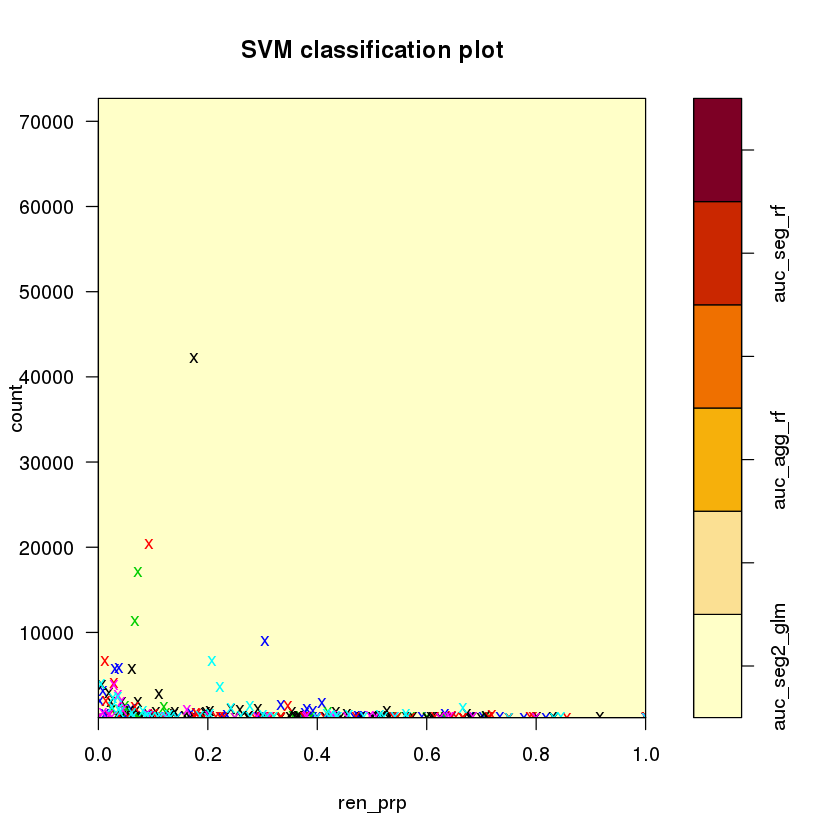

In [65]:
# The svm() algorithm also has a special plot() function that we can use to visualize the support vectors 
# (shown with “x”), the decision boundary, and the margin for the model. The plot helps to visualize a two-dimensional 
# projection of the data (using the Petal.Width and Petal.Length predictors) with Species classes 
# (shown in different shadings) and support vectors. We can also use the slice argument to specify a list of named 
# values for the dimensions held constant (useful when more than two variables are used).
plot(svm_auc_01, train_auc, count ~ ren_prp)
     #,
     #     slice=list(Sepal.Width=3, Sepal.Length=4))

In [66]:
prediction <- predict(svm_auc_01, test,na.action = na.exclude)
xtab <- table(test$auc_win, prediction)
xtab

              prediction
               auc_seg2_glm auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf
  auc_agg_glm             9           0          0           0          0
  auc_agg_rf             11           0          0           0          0
  auc_seg_glm            11           0          0           0          0
  auc_seg_rf             16           0          0           0          0
  auc_seg2_glm           28           0          0           0          0
  auc_seg2_rf             8           0          0           0          0
              prediction
               auc_seg2_rf
  auc_agg_glm            0
  auc_agg_rf             0
  auc_seg_glm            0
  auc_seg_rf             0
  auc_seg2_glm           0
  auc_seg2_rf            0

In [67]:
# Finally, we can check the accuracy of the algorithm with the following R code. 
# The metric shows how well the trained algorithm makes predictions using the test set. 
# The 8.7% accuracy is bad
(30)/nrow(test)  # Compute prediction accuracy

[1] 0.1415094

## Hyperparam tuning

In [68]:
obj <- tune.svm(auc_win~., data=train_auc, 
                gamma = 2^(-1:1), cost = 2^(2:4))

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘pdcnt_min’ constant. Cannot scale data.”
Warning message in svm.default(x, y, scale = sca

In [69]:
summary(obj)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
   0.5    4

- best performance: 0.6940521 

- Detailed performance results:
  gamma cost     error dispersion
1   0.5    4 0.6940521 0.07934536
2   1.0    4 0.6940521 0.07934536
3   2.0    4 0.6940521 0.07934536
4   0.5    8 0.6940521 0.07934536
5   1.0    8 0.6940521 0.07934536
6   2.0    8 0.6940521 0.07934536
7   0.5   16 0.6940521 0.07934536
8   1.0   16 0.6940521 0.07934536
9   2.0   16 0.6940521 0.07934536


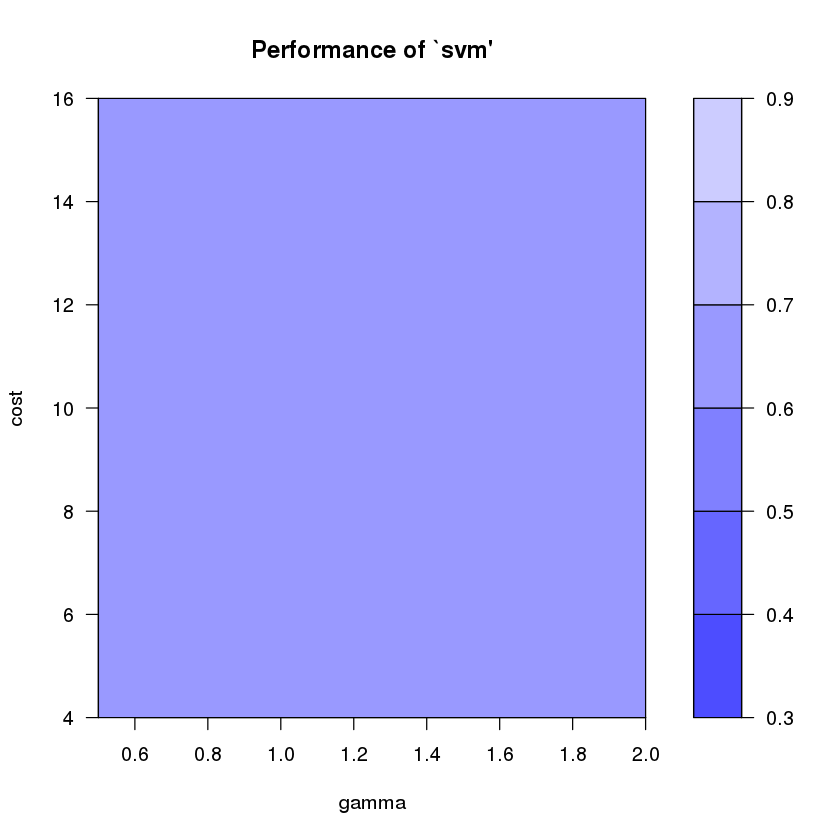

In [70]:
plot(obj)

In [71]:
# suppressWarnings(obj <- tune.svm(auc_win~., data=train_auc, 
#                 gamma = 2^(-1:1), cost = 2^(2:4),
#                kernel='linear'))
# summary(obj)
# plot(obj)

In [73]:
1

[1] 1


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
   0.5    4

- best performance: 0.8691209 

- Detailed performance results:
  gamma cost     error dispersion
1   0.5    4 0.8691209  0.0665962
2   1.0    4 0.8691209  0.0665962
3   2.0    4 0.8691209  0.0665962
4   0.5    8 0.8691209  0.0665962
5   1.0    8 0.8691209  0.0665962
6   2.0    8 0.8691209  0.0665962
7   0.5   16 0.8691209  0.0665962
8   1.0   16 0.8691209  0.0665962
9   2.0   16 0.8691209  0.0665962


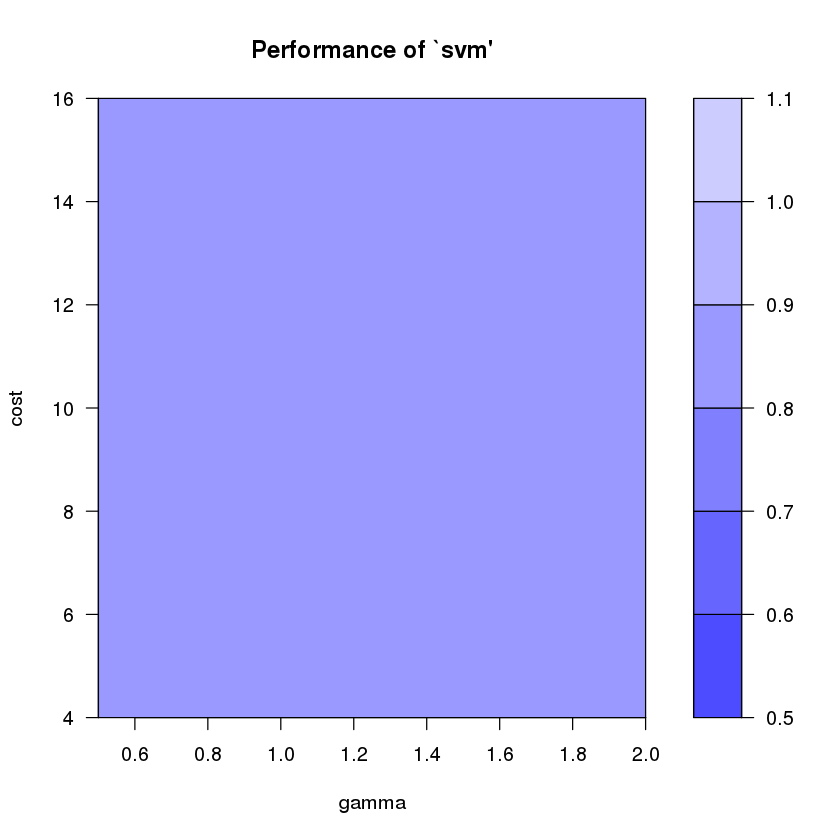

In [72]:
suppressWarnings(obj <- tune.svm(auc_win~., data=train_auc, 
                gamma = 2^(-1:1), cost = 2^(2:4),
               kernel='polynomial'))
summary(obj)
plot(obj)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
   0.5    4

- best performance: 0.695964 

- Detailed performance results:
  gamma cost    error dispersion
1   0.5    4 0.695964 0.06737388
2   1.0    4 0.695964 0.06737388
3   2.0    4 0.695964 0.06737388
4   0.5    8 0.695964 0.06737388
5   1.0    8 0.695964 0.06737388
6   2.0    8 0.695964 0.06737388
7   0.5   16 0.695964 0.06737388
8   1.0   16 0.695964 0.06737388
9   2.0   16 0.695964 0.06737388


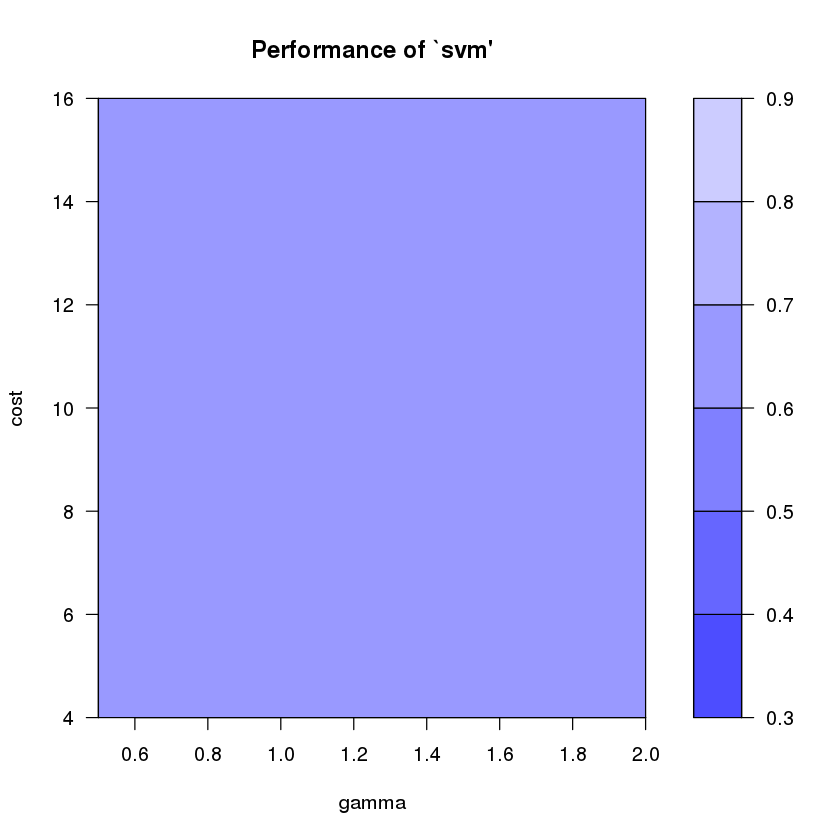

In [74]:
suppressWarnings(obj <- tune.svm(auc_win~., data=train_auc, 
                gamma = 2^(-1:1), cost = 2^(2:4),
               kernel='sigmoid'))
summary(obj)
plot(obj)